In [1]:
### Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch
import hdbscan

In [2]:
### Read CSV file & Future Formatting
df_data = pd.read_csv("data.csv")
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = "{:.2f}".format

# Identify unnecessary and target columns
DROP_LABELS = ["Flow ID", "Src IP", "Src Port", "Dst IP", "Dst Port", "Timestamp"]
TARGET_LABELS = ["Label", "Traffic Type", "Traffic Subtype"]

In [3]:
### Data introduction
# Sampling
def sampling(df: pd.DataFrame, cap: int, rate: float, notext=False) -> pd.DataFrame:
    if notext == False:
        print("Dataset before sampling has", df.shape[0], "rows and", df.shape[1], "columns")
        print("Sampling ...")

    if cap != 0:
        subtype_counts = df["Traffic Subtype"].value_counts()  # All the traffic subtypes
        subtypes_sampling = subtype_counts[subtype_counts > cap].index    # All the traffic subtypes with over 10000 rows
        subtypes_nosampling = subtype_counts[subtype_counts <= cap].index # All the traffic subtypes with under 10000 rows
        
        df_sampling = df[df["Traffic Subtype"].isin(subtypes_sampling)]   # DataFrame with all the oversized traffic subtypes
        df_sampled = df_sampling.sample(frac=rate)  # Sampled DataFrame for oversized traffic types
        df_notsampled = df[df["Traffic Subtype"].isin(subtypes_nosampling)]   # DataFrame for rest of traffic types
        df_final =  pd.concat([df_sampled, df_notsampled], ignore_index=True)  # Final  partially sampled DataFrame

    else:
        df_final = df.sample(frac=rate)
        
    if notext == False:
        print("Dataset after sampling has", df_final.shape[0], "rows and", df_final.shape[1], "columns")
    
    return df_final

# Drop unnecessary data
def drop_unnecessary(df: pd.DataFrame) -> pd.DataFrame:
    print("Dataset before removing unnecessary data has", df.shape[0], "rows and", df.shape[1], "columns")
    print("Removing unnecessary data ...")
    df_final =  df.drop(columns=DROP_LABELS)
    print("Dataset after removing unnecessary data has", df_final.shape[0], "rows and", df_final.shape[1], "columns")
    
    return df_final

# Data presentation
def present(df: pd.DataFrame):
    display(df.head())
    display(df.tail())
    display(df.describe().T)
    display(df.groupby(TARGET_LABELS).size().reset_index(name="Counts"))

In [33]:
### Correlation, target correlation and intresting columns
LABEL_MAPPER = {"Malicious": 1, "Benign": 0}
TYPES_MAPPER = {"Audio": 0, "Background": 1, "Text": 2, "Video": 3, "Bruteforce": 4, "DoS": 5, "Information Gathering": 6, "Mirai": 7}

def labels_to_numerical(df: pd.DataFrame, mapper: dict) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Label"] = df_copy["Label"].map(mapper)
    return df_copy

def ttypes_to_numerical(df: pd.DataFrame, mapper: dict) -> pd.DataFrame:
    df_copy = df.copy()
    df_copy["Traffic Type"] = df_copy["Traffic Type"].map(mapper)
    return df_copy

def correlation(df_numerical: pd.DataFrame, target=False):
    if target == True:
        important_metrics_label = []
        important_metrics_ttype = []
        df_copy = df_numerical.copy()
        df_norm = (df_copy - df_copy.min()) / (df_copy.max() - df_copy.min())
        cor = df_norm.corr(numeric_only=True).filter(["Label", "Traffic Type"])

        for r in cor.index.tolist():
            if abs(cor.at[r, "Label"]) > 0.1 and r != "Traffic Type":
                important_metrics_label.append(r)
            if abs(cor.at[r, "Traffic Type"]) > 0.1 and r != "Label":
                important_metrics_ttype.append(r)

        print(len(important_metrics_label), "Metrics with high correlation with Label")
        print(len(important_metrics_ttype), "Metrics with high correlation with Traffic Type")
        return cor, important_metrics_label, important_metrics_ttype

    else:
        df_copy = df_numerical.copy()
        df_norm = (df_copy - df_copy.min()) / (df_copy.max() - df_copy.min())
        return df_norm.corr(numeric_only=True)

In [26]:
### Data Visualization
# Create heatmap from correlation Pandas Dataframe
def heatmap(corr: pd.DataFrame, title: str) -> None:
    print("Generating heatmap ...")
    plt.figure(figsize=(30, 20))
    sns.heatmap(corr, cmap="coolwarm", square=True)
    plt.title(title)
    plt.show()

# Create boxplot diagram to showcase target differences
def boxplot(df: pd.DataFrame, df_complete: pd.DataFrame,  title: str, y_lim_bot: float, y_lim_top: float) -> None:
    print("Generating boxplot ...")
    df_copy = df.copy()
    df_norm = (df_copy - df_complete.min()) / (df_complete.max() - df_complete.min())
    plt.figure(figsize=(15, 5))
    sns.boxplot(data=df_norm)
    plt.ylim((y_lim_bot, y_lim_top))
    plt.xticks(rotation = 65, ha = "right")
    plt.title(title)
    plt.show()

# Create barplot to showcase certain values
def barplot(x, y, title: str) -> None:
    print("Generating barplot ...")
    plt.figure(figsize=(15, 5))
    sns.barplot(x=x, y=y)
    plt.ylim((-1, 1))
    plt.xticks(rotation = 65, ha = "right")
    plt.title(title)
    plt.grid(True, axis="y")
    plt.show()

In [6]:
### Dimensionality Reduction
PCA_COLS = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10", "PC11", "PC12", "PC13", "PC14", "PC15"]

def dim_reduction(df: pd.DataFrame, N: int, method: str) -> pd.DataFrame:
    if method == "PCA":
        scaler = StandardScaler()
        df_scaled = scaler.fit_transform(df)
        pca = PCA(n_components=N)
        principal_components = pca.fit_transform(df_scaled)
        df_final = pd.DataFrame(data=principal_components, columns=PCA_COLS[:N])
        print("PCA METHOD --> Cumulative variance:", pca.explained_variance_ratio_.cumsum()[-1])
    
    return df_final

In [7]:
### Clustering
# BIRCH Algorithm
def BIRCH_clustering(df: pd.DataFrame,) -> pd.DataFrame:
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    clusterer = Birch(n_clusters=None)
    clusterer.fit(df_scaled)
    df["Cluster"] = clusterer.labels_
    return df

# HDBSCAN Algorithm
def HDBSCAN_clustering(df: pd.DataFrame, minimum_cluster_size: int) -> pd.DataFrame:
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=minimum_cluster_size, metric="euclidean")
    clusters = clusterer.fit_predict(df_scaled)
    df["Cluster"] = clusters
    return df

# Present HDBSCAN results
def HDBSCAN_results(df: pd.DataFrame):
    sns.countplot(x="HDBSCAN_Cluster", data=df)
    

In [8]:
### Initial sampling, remove excess metrics and duplicates in order to create plots in reasonable time, present data
df = sampling(df_data, cap=10000, rate=0.025)
df = drop_unnecessary(df)
present(df)

Dataset before sampling has 8656767 rows and 86 columns
Sampling ...
Dataset after sampling has 251450 rows and 86 columns
Dataset before removing unnecessary data has 251450 rows and 86 columns
Removing unnecessary data ...
Dataset after removing unnecessary data has 251450 rows and 80 columns


Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
0      6.00       27603.00              1.00               1.00   
1      6.00    10009214.00              2.00               0.00   
2      6.00    20106880.00              4.00               1.00   
3      6.00    49836397.00              4.00               1.00   
4      6.00        3791.00              1.00               1.00   

   Total Length of Fwd Packet  Total Length of Bwd Packet  \
0                      500.00                        0.00   
1                     1000.00                        0.00   
2                     1960.00                        0.00   
3                      200.00                        0.00   
4                       50.00                        0.00   

   Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
0                 500.00                 500.00                  500.00   
1                 500.00                 500.00                  500.00   
2                 500.00                 480.00                  490.00   
3                  50.00                  50.00                   50.00   
4                  50.00                  50.00                   50.00   

   Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  \
0                   0.00                   0.00                   0.00   
1                   0.00                   0.00                   0.00   
2                  11.55                   0.00                   0.00   
3                   0.00                   0.00                   0.00   
4                   0.00                   0.00                   0.00   

   Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  \
0                    0.00                   0.00      18113.97   
1                    0.00                   0.00         99.91   
2                    0.00                   0.00         97.48   
3                    0.00                   0.00          4.01   
4                    0.00                   0.00      13189.13   

   Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  Flow IAT Min  \
0           72.46       27603.00          0.00      27603.00      27603.00   
1            0.20    10009214.00          0.00   10009214.00   10009214.00   
2            0.25     5026720.00    4371338.42    9984359.00      74594.00   
3            0.10    12459099.25   13937695.21   30421232.00      68533.00   
4          527.57        3791.00          0.00       3791.00       3791.00   

   Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  Fwd IAT Min  \
0           0.00          0.00         0.00         0.00         0.00   
1    10009214.00   10009214.00         0.00  10009214.00  10009214.00   
2    20032286.00    6677428.67   3509111.67   9984359.00   2996151.00   
3    49767864.00   16589288.00  13749118.77  30421232.00   2924519.00   
4           0.00          0.00         0.00         0.00         0.00   

   Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  Bwd IAT Min  \
0           0.00          0.00         0.00         0.00         0.00   
1           0.00          0.00         0.00         0.00         0.00   
2           0.00          0.00         0.00         0.00         0.00   
3           0.00          0.00         0.00         0.00         0.00   
4           0.00          0.00         0.00         0.00         0.00   

   Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  Bwd URG Flags  \
0           0.00           0.00           0.00           0.00   
1           0.00           0.00           1.00           0.00   
2           1.00           0.00           0.00           0.00   
3           0.00           0.00           0.00           0.00   
4           0.00           0.00           0.00           0.00   

   Fwd Header Length  Bwd Header Length  Fwd Packets/s  Bwd Packets/s  \
0              20.00              20.00          36.23          36.23   
1              40.00               0.00           0.20  

Protocol  Flow Duration  Total Fwd Packet  Total Bwd packets  \
251445     17.00    22485411.00           2307.00               0.00   
251446      0.00    65027682.00              9.00               0.00   
251447     17.00    49795393.00           5256.00               0.00   
251448     17.00     8809176.00            596.00               0.00   
251449     17.00     2856556.00            477.00               0.00   

        Total Length of Fwd Packet  Total Length of Bwd Packet  \
251445                  3036012.00                        0.00   
251446                        0.00                        0.00   
251447                  6916896.00                        0.00   
251448                   784336.00                        0.00   
251449                   627732.00                        0.00   

        Fwd Packet Length Max  Fwd Packet Length Min  Fwd Packet Length Mean  \
251445                1316.00                1316.00                 1316.00   
251446                   0.00                   0.00                    0.00   
251447                1316.00                1316.00                 1316.00   
251448                1316.00                1316.00                 1316.00   
251449                1316.00                1316.00                 1316.00   

        Fwd Packet Length Std  Bwd Packet Length Max  Bwd Packet Length Min  \
251445                   0.00                   0.00                   0.00   
251446                   0.00                   0.00                   0.00   
251447                   0.00                   0.00                   0.00   
251448                   0.00                   0.00                   0.00   
251449                   0.00                   0.00                   0.00   

        Bwd Packet Length Mean  Bwd Packet Length Std  Flow Bytes/s  \
251445                    0.00                   0.00     135021.41   
251446                    0.00                   0.00          0.00   
251447                    0.00                   0.00     138906.34   
251448                    0.00                   0.00      89036.25   
251449                    0.00                   0.00     219751.34   

        Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Max  \
251445          102.60        9750.83       2943.43      34364.00   
251446            0.14     8128460.25   13829860.15   38099180.00   
251447          105.55        9475.81      46833.33     482563.00   
251448           67.66       14805.34      62796.18     773425.00   
251449          166.98        6001.17       3897.52      25978.00   

        Flow IAT Min  Fwd IAT Total  Fwd IAT Mean  Fwd IAT Std  Fwd IAT Max  \
251445         30.00    22485411.00       9750.83      2943.43     34364.00   
251446        403.00    65027682.00    8128460.25  13829860.15  38099180.00   
251447          0.00    49795393.00       9475.81     46833.33    482563.00   
251448          0.00     8809176.00      14805.34     62796.18    773425.00   
251449         17.00     2856556.00       6001.17      3897.52     25978.00   

        Fwd IAT Min  Bwd IAT Total  Bwd IAT Mean  Bwd IAT Std  Bwd IAT Max  \
251445        30.00           0.00          0.00         0.00         0.00   
251446       403.00           0.00          0.00         0.00         0.00   
251447         0.00           0.00          0.00         0.00         0.00   
251448         0.00           0.00          0.00         0.00         0.00   
251449        17.00           0.00          0.00         0.00         0.00   

        Bwd IAT Min  Fwd PSH Flags  Bwd PSH Flags  Fwd URG Flags  \
251445         0.00           0.00           0.00           0.00   
251446         0.00           0.00           0.00           0.00   
251447         0.00           0.00           0.00           0.00   
251448         0.00           0.00           0.00           0.00   
251449         0.00           0.00           0.00           0.00   

        Bwd URG Flags  Fwd 

count       mean         std     min      25%  \
Protocol                   251450.00       6.40        2.08    0.00     6.00   
Flow Duration              251450.00 8762150.41 13393277.47    1.00 46516.25   
Total Fwd Packet           251450.00      16.71     1118.37    1.00     1.00   
Total Bwd packets          251450.00       9.38      594.21    0.00     0.00   
Total Length of Fwd Packet 251450.00    6661.51   255101.49    0.00    50.00   
Total Length of Bwd Packet 251450.00    4793.08   164675.72    0.00     0.00   
Fwd Packet Length Max      251450.00     280.12      368.19    0.00    30.00   
Fwd Packet Length Min      251450.00     257.15      357.00    0.00    30.00   
Fwd Packet Length Mean     251450.00     264.11      356.82    0.00    30.00   
Fwd Packet Length Std      251450.00       8.99       49.85    0.00     0.00   
Bwd Packet Length Max      251450.00      23.03      153.70    0.00     0.00   
Bwd Packet Length Min      251450.00       2.93       59.97    0.00     0.00   
Bwd Packet Length Mean     251450.00       9.22       91.44    0.00     0.00   
Bwd Packet Length Std      251450.00       6.40       51.07    0.00     0.00   
Flow Bytes/s               251450.00   14192.62  1213009.63    0.00     7.76   
Flow Packets/s             251450.00    2327.71    23457.89    0.02     0.26   
Flow IAT Mean              251450.00 4172472.68  6612935.05    1.00 44067.25   
Flow IAT Std               251450.00 2031845.14  4298154.73    0.00     0.00   
Flow IAT Max               251450.00 6309875.27  9104789.29    1.00 46139.75   
Flow IAT Min               251450.00 2622911.74  6098717.92 -945.00 22373.25   
Fwd IAT Total              251450.00 8283362.50 13136106.37    0.00     0.00   
Fwd IAT Mean               251450.00 4857914.32  7508429.23    0.00     0.00   
Fwd IAT Std                251450.00  993723.53  2956146.99    0.00     0.00   
Fwd IAT Max                251450.00 5983716.16  8852026.71    0.00     0.00   
Fwd IAT Min                251450.00 4128685.85  7202808.66    0.00     0.00   
Bwd IAT Total              251450.00  853230.58  5199150.12    0.00     0.00   
Bwd IAT Mean               251450.00  109679.79   709635.02    0.00     0.00   
Bwd IAT Std                251450.00  204952.93  1332838.53    0.00     0.00   
Bwd IAT Max                251450.00  478502.50  2976538.50    0.00     0.00   
Bwd IAT Min                251450.00   11093.02   290728.99    0.00     0.00   
Fwd PSH Flags              251450.00       0.11        0.31    0.00     0.00   
Bwd PSH Flags              251450.00       0.00        0.00    0.00     0.00   
Fwd URG Flags              251450.00       0.10        0.30    0.00     0.00   
Bwd URG Flags              251450.00       0.00        0.00    0.00     0.00   
Fwd Header Length          251450.00     266.92     4324.79    0.00    20.00   
Bwd Header Length          251450.00     200.46     4588.04    0.00     0.00   
Fwd Packets/s              251450.00    2297.01    23438.01    0.02     0.21   
Bwd Packets/s              251450.00      30.69      594.92    0.00     0.00   
Packet Length Min          251450.00      93.42      262.71    0.00     0.00   
Packet Length Max          251450.00     292.56      380.87    0.00    50.00   
Packet Length Mean         251450.00     218.99      304.45    0.00    30.00   
Packet Length Std          251450.00      99.73      168.68    0.00     0.00   
Packet Length Variance     251450.00   38398.41   107289.14    0.00     0.00   
FIN Flag Count             251450.00       0.24        0.57    0.00     0.00   
SYN Flag Count             251450.00       0.62        5.91    0.00     0.00   
RST Flag Count             251450.00       0.96        0.60    0.00     1.00   
PSH Flag Count             251450.00       4.57      110.70    0.00     0.00   
ACK Flag Count             251450.00      11.47      252.33    0.00     0.00   
URG Flag Count             251450.00       0.18        0.66    0.00     0.00   
CWR Flag Count             2514

Label           Traffic Type        Traffic Subtype  Counts
0      Benign                  Audio                  Audio     190
1      Benign             Background             Background      32
2      Benign                   Text                   Text     209
3      Benign                  Video             Video HTTP     376
4      Benign                  Video              Video RTP     349
5      Benign                  Video              Video UDP     145
6   Malicious             Bruteforce         Bruteforce DNS     569
7   Malicious             Bruteforce         Bruteforce FTP    3485
8   Malicious             Bruteforce        Bruteforce HTTP     628
9   Malicious             Bruteforce         Bruteforce SSH    3967
10  Malicious             Bruteforce      Bruteforce Telnet    4913
11  Malicious                    DoS                DoS ACK   23031
12  Malicious                    DoS                DoS CWR   21682
13  Malicious                    DoS                DoS ECN   21686
14  Malicious                    DoS                DoS FIN   18215
15  Malicious                    DoS               DoS HTTP    2079
16  Malicious                    DoS               DoS ICMP       9
17  Malicious                    DoS                DoS MAC      30
18  Malicious                    DoS                DoS PSH   22779
19  Malicious                    DoS                DoS RST   26721
20  Malicious                    DoS                DoS SYN   21692
21  Malicious                    DoS                DoS UDP    6537
22  Malicious                    DoS                DoS URG   22734
23  Malicious  Information Gathering  Information Gathering   26050
24  Malicious                  Mirai         Mirai DDoS ACK    3779
25  Malicious                  Mirai         Mirai DDoS DNS    1367
26  Malicious                  Mirai      Mirai DDoS GREETH      43
27  Malicious                  Mirai       Mirai DDoS GREIP      49
28  Malicious                  Mirai        Mirai DDoS HTTP    8923
29  Malicious                  Mirai         Mirai DDoS SYN     379
30  Malicious                  Mirai         Mirai DDoS UDP      71
31  Malicious                  Mirai  Mirai Scan Bruteforce    8731

Generating boxplot ...


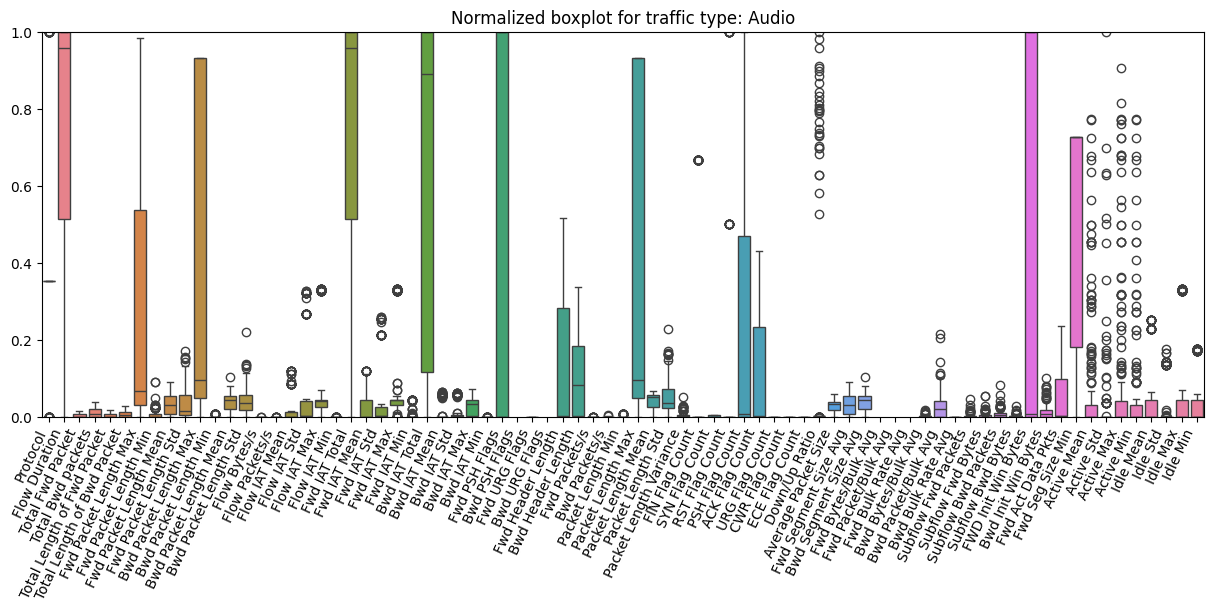

Generating boxplot ...


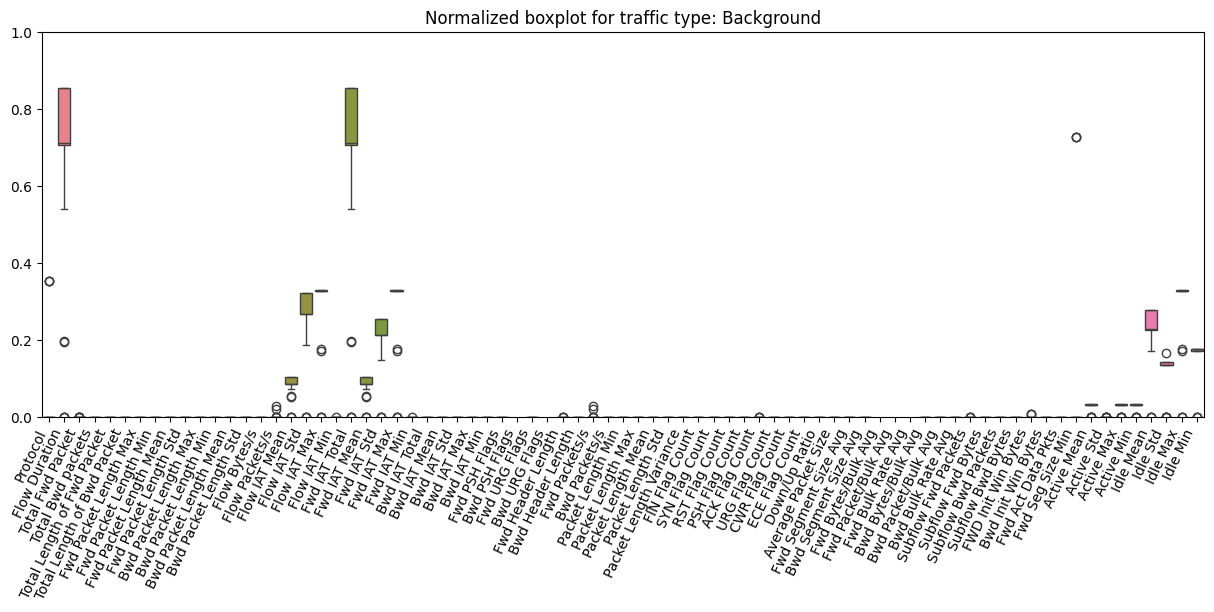

Generating boxplot ...


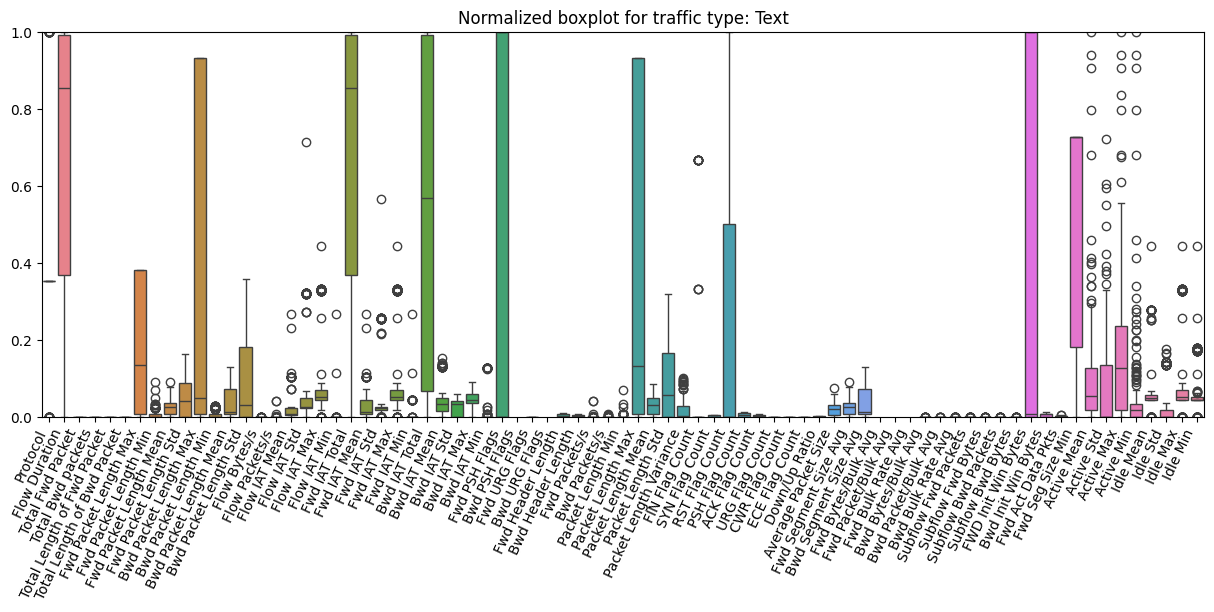

Generating boxplot ...


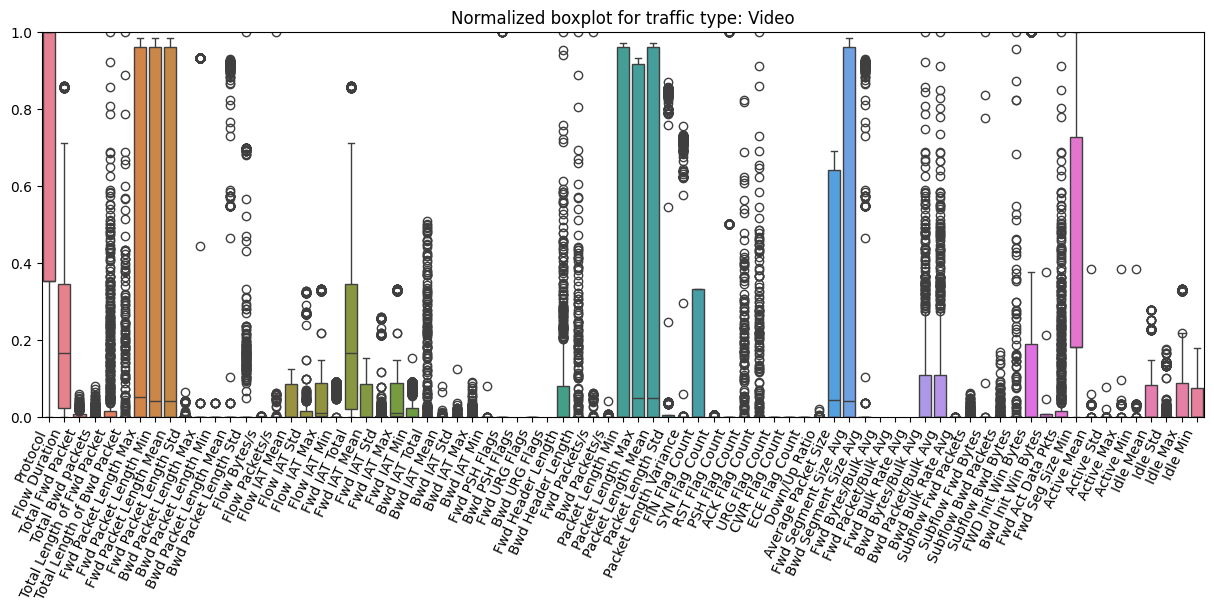

Generating boxplot ...


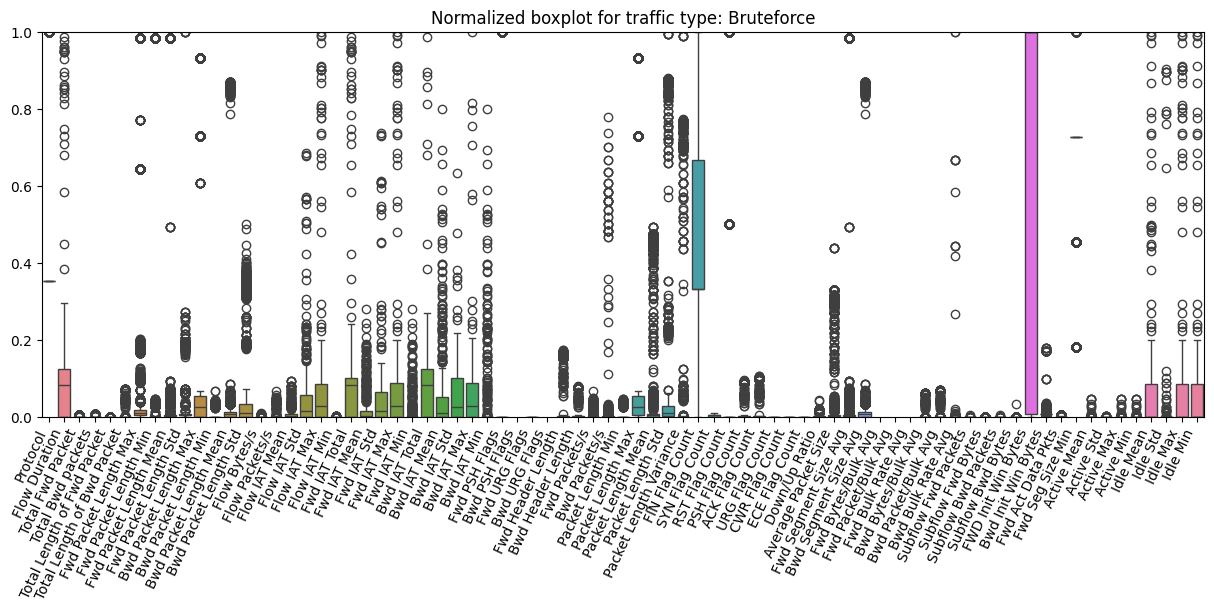

Generating boxplot ...


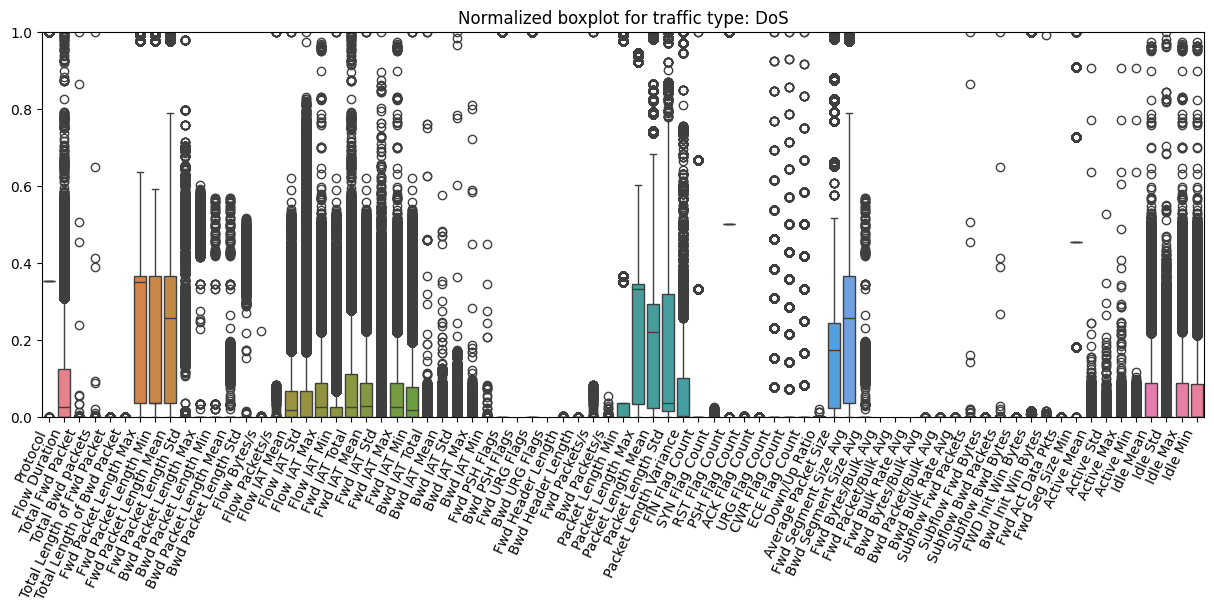

Generating boxplot ...


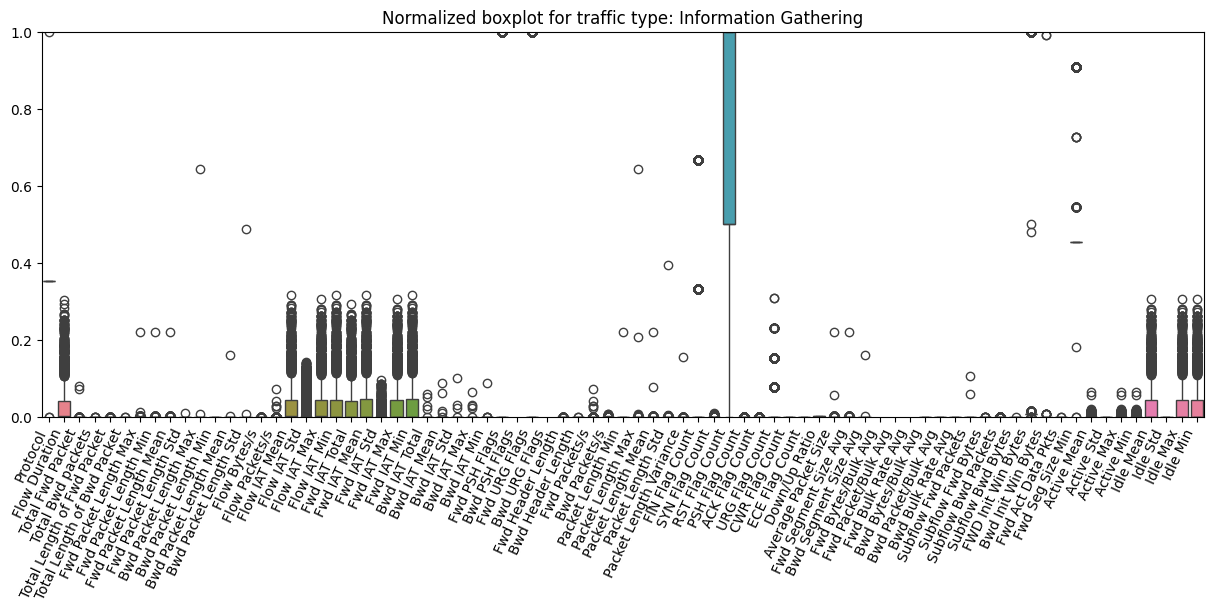

Generating boxplot ...


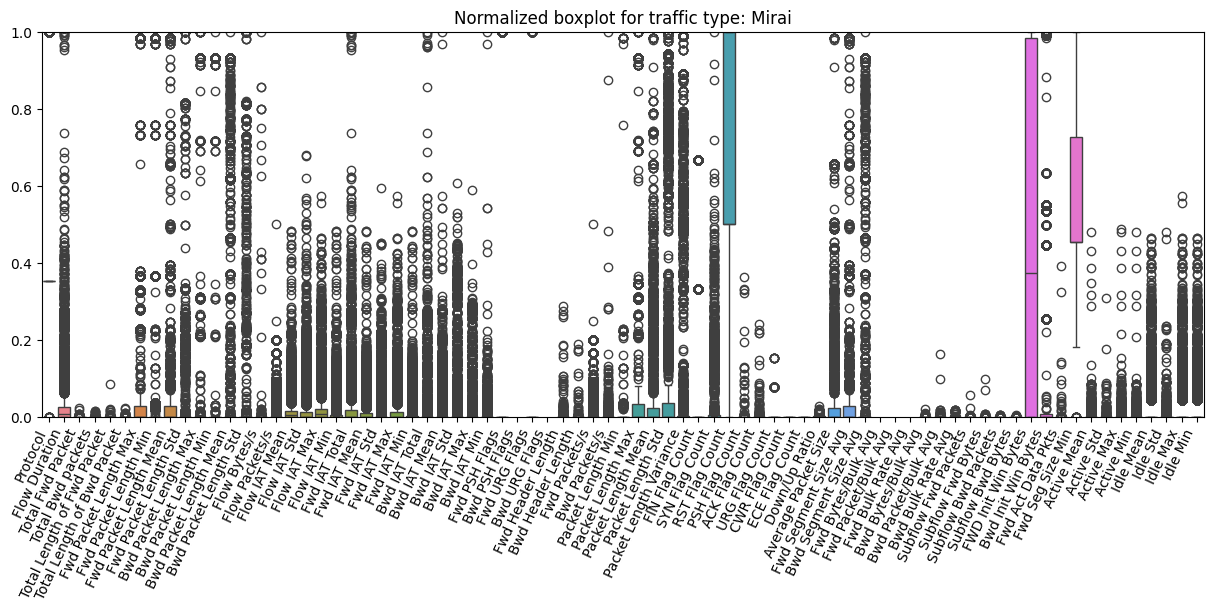

Generating boxplot ...


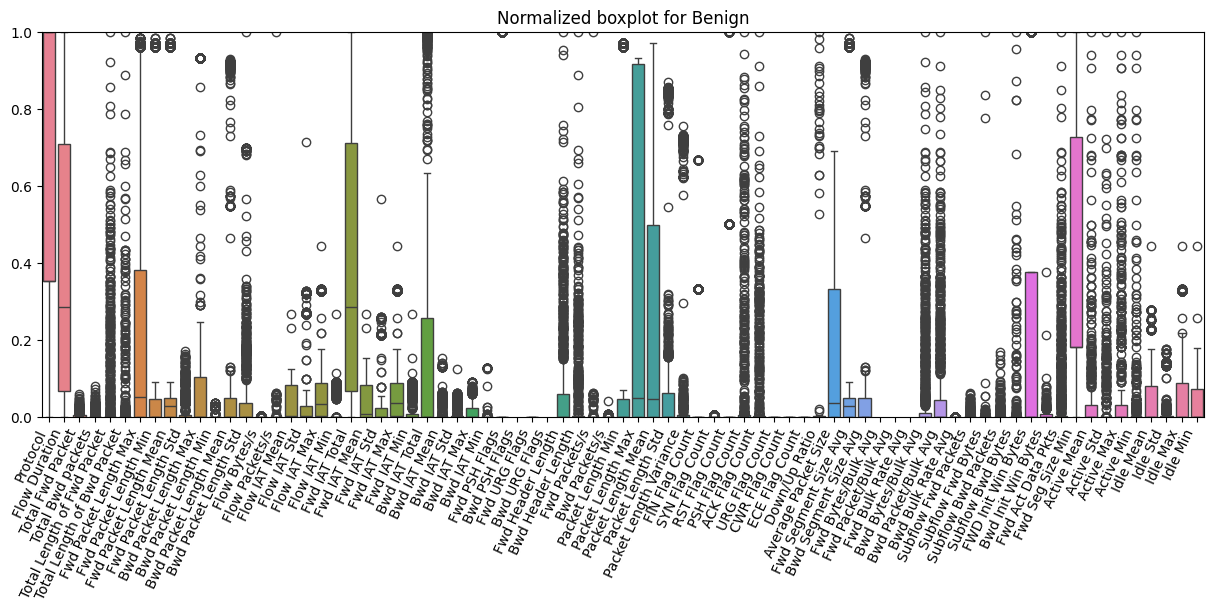

Generating boxplot ...


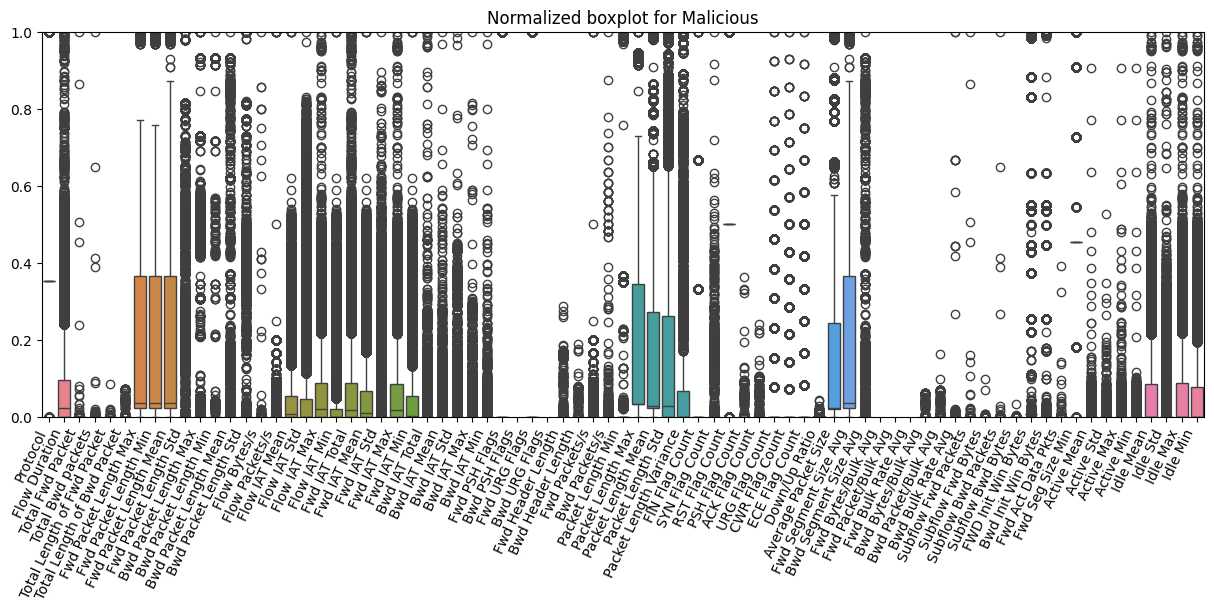

In [27]:
### Present distributions for all metrics for both Benign and Malicious labels
ylim_top = 1
ylim_bot = 0
df_benign = df[df["Label"] == "Benign"]
df_malicious = df[df["Label"] == "Malicious"]

benign_list = ["Audio", "Background", "Text", "Video"]
malicious_list = ["Bruteforce", "DoS", "Information Gathering", "Mirai"]

for ttype in benign_list:
    boxplot(df_benign[df_benign["Traffic Type"] == ttype].drop(columns=TARGET_LABELS), df.drop(columns=TARGET_LABELS), "Normalized boxplot for traffic type: " + ttype, ylim_bot, ylim_top)

for ttype in malicious_list:
    boxplot(df_malicious[df_malicious["Traffic Type"] == ttype].drop(columns=TARGET_LABELS), df.drop(columns=TARGET_LABELS), "Normalized boxplot for traffic type: " + ttype, ylim_bot, ylim_top)

boxplot(df_benign.drop(columns=TARGET_LABELS), df.drop(columns=TARGET_LABELS), "Normalized boxplot for Benign", ylim_bot, ylim_top)
boxplot(df_malicious.drop(columns=TARGET_LABELS), df.drop(columns=TARGET_LABELS), "Normalized boxplot for Malicious", ylim_bot, ylim_top)

In [34]:
# Convert all data to numerical and compute correlations
df_num = labels_to_numerical(df, LABEL_MAPPER)
df_num = ttypes_to_numerical(df_num, TYPES_MAPPER).select_dtypes(include="number")

cor1 = correlation(df_num)
cor2, important_metrics_label, important_metrics_ttype = correlation(df_num, target=True)

23 Metrics with high correlation with Label
31 Metrics with high correlation with Traffic Type


Generating heatmap ...


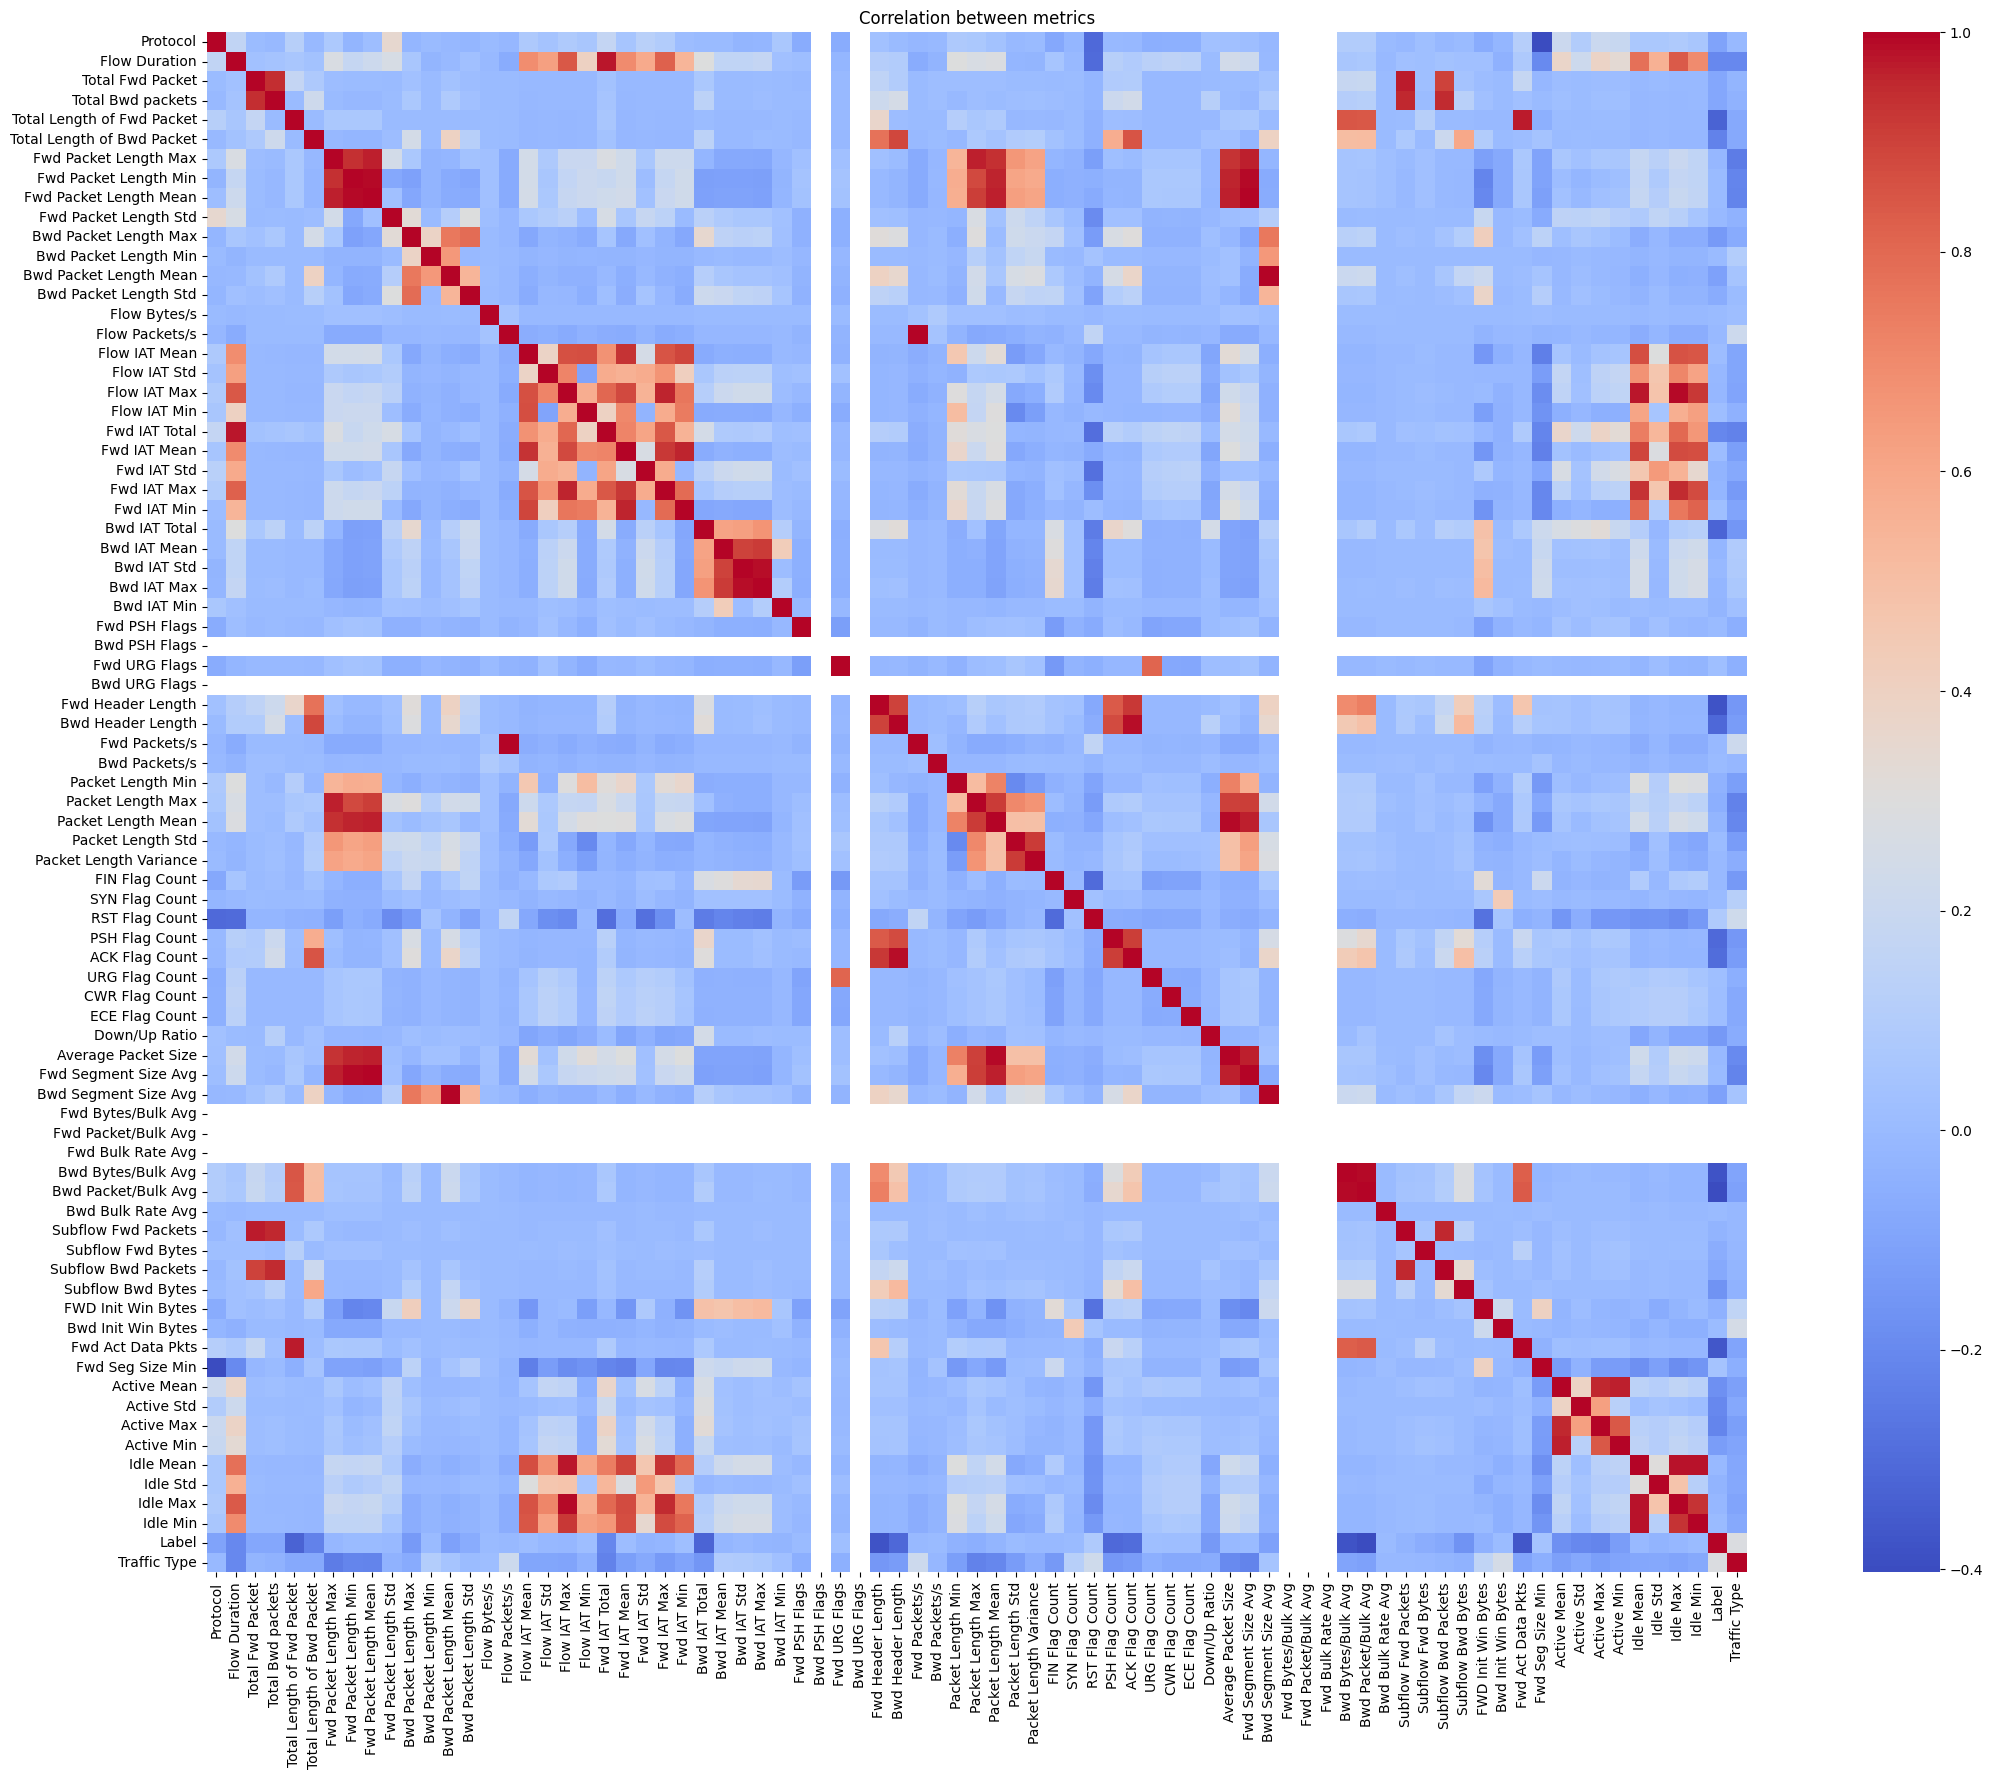

Generating heatmap ...


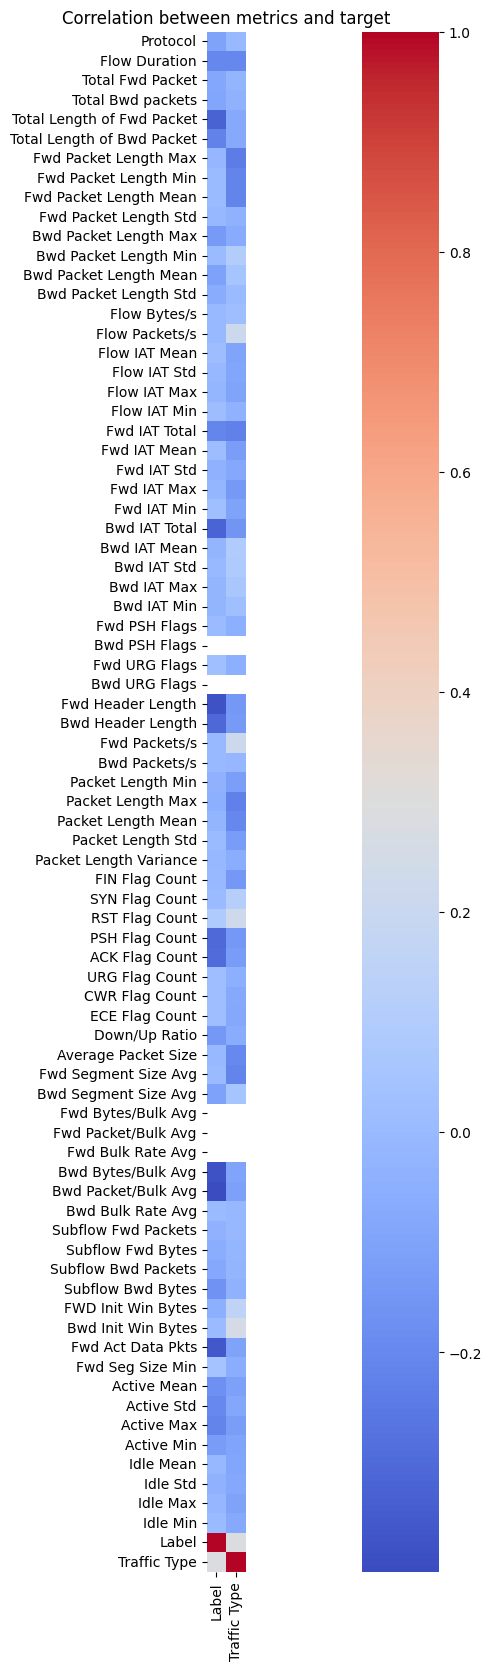

In [35]:
### Create heatmaps
heatmap(cor1, "Correlation between metrics")
heatmap(cor2, "Correlation between metrics and target")

Generating barplot ...


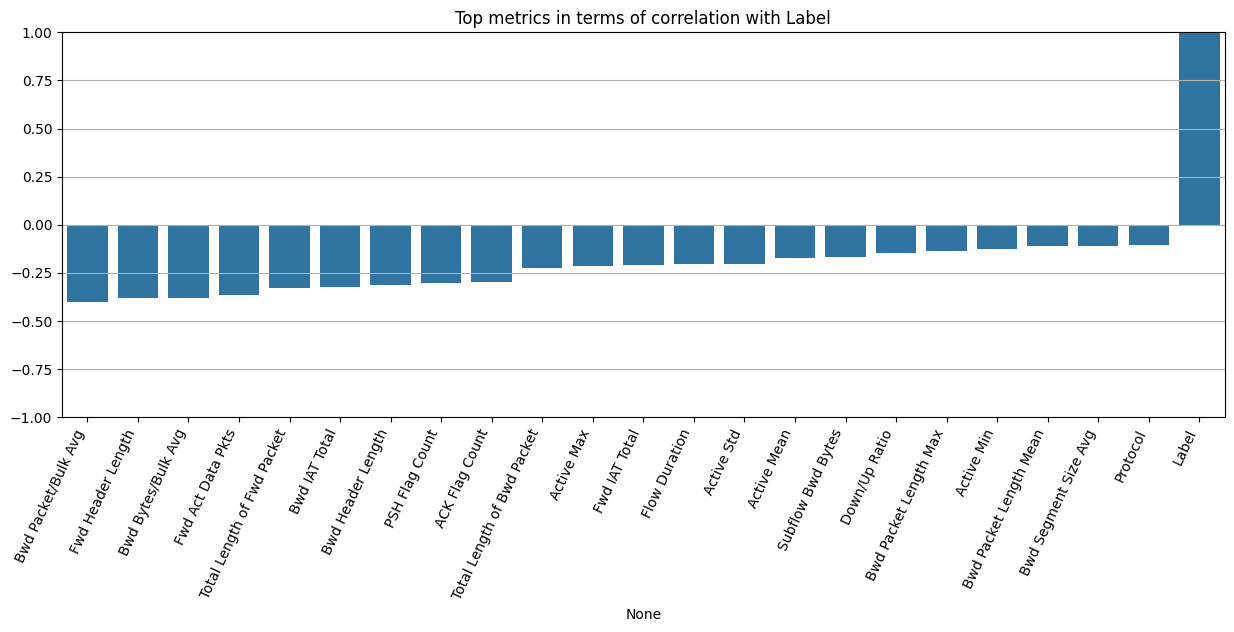

Generating barplot ...


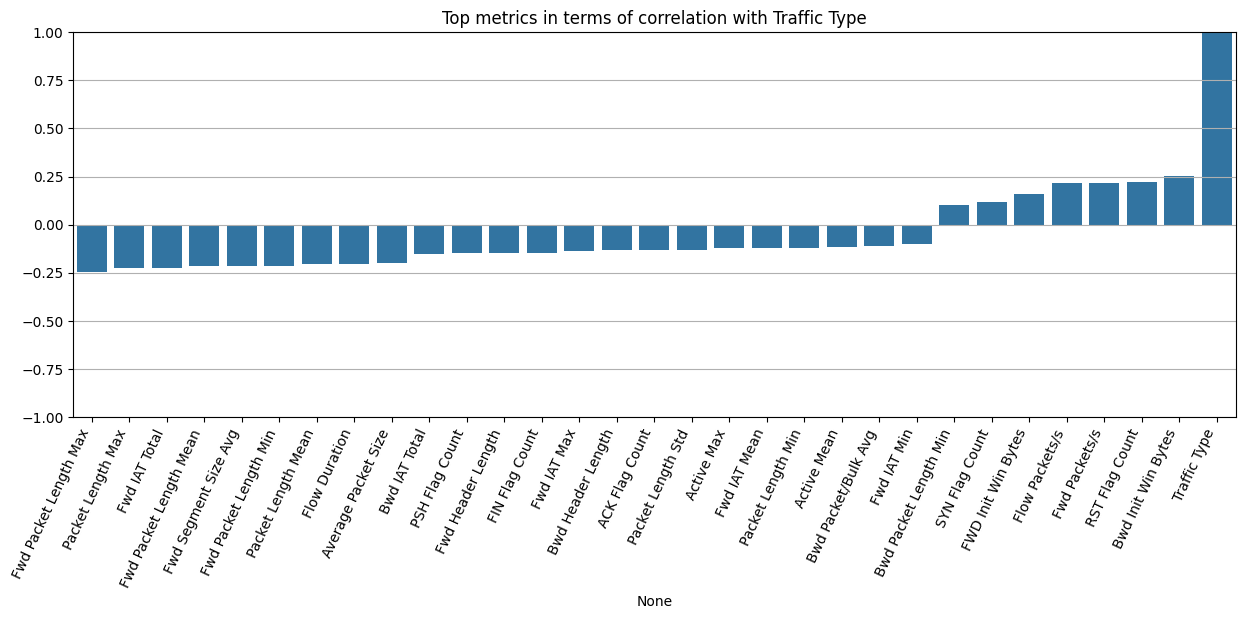

In [36]:
### Showcase top correlations
df_important_metrics_label_count = cor2.filter(items=important_metrics_label, axis="index").filter(["Label"]).sort_values(by="Label")
barplot(
    df_important_metrics_label_count.index, df_important_metrics_label_count.values.reshape(len(df_important_metrics_label_count.index)),
    "Top metrics in terms of correlation with Label"
)

df_important_metrics_ttype_count = cor2.filter(items=important_metrics_ttype, axis="index").filter(["Traffic Type"]).sort_values(by="Traffic Type")
barplot(
    df_important_metrics_ttype_count.index, df_important_metrics_ttype_count.values.reshape(len(df_important_metrics_ttype_count.index)),
    "Top metrics in terms of correlation with Traffic Type"
)

In [37]:
### DataFrames with metrics highly correlated with targets, dimension reduction
DIM_TARGET = 10
df_label = df_num[important_metrics_label]
df_ttype = df_num[important_metrics_ttype]

print("Target Label:")
df_labelDimReduction = dim_reduction(df_label.drop(columns=["Label"]), DIM_TARGET, "PCA")
df_labelDimReduction["Label"] = df_label["Label"]
print("Target Traffic Type:")
df_ttypeDimReduction = dim_reduction(df_ttype.drop(columns=["Traffic Type"]), DIM_TARGET, "PCA")
df_ttypeDimReduction["Traffic Type"] = df_ttype["Traffic Type"]


Target Label:
PCA METHOD --> Cumulative variance: 0.9695640000773328
Target Traffic Type:
PCA METHOD --> Cumulative variance: 0.8931627215533768


In [38]:
### Sampling, Clustering with Kmeans, Clustering with BIRCH
# Data reduction through sampling
df_label_sampling = sampling(df_labelDimReduction, 0, 0.3, notext=True)
df_ttype_sampling = sampling(df_ttypeDimReduction, 0, 0.3, notext=True)

# Data reduction through BIRCH clustering
df_label_BIRCH = BIRCH_clustering(df_labelDimReduction.drop(columns=["Label"]))
df_ttype_BIRCH = BIRCH_clustering(df_ttypeDimReduction.drop(columns=["Traffic Type"]))

# Data reduction through HDBSCAN clustering
df_label_HDBSCAN = HDBSCAN_clustering(df_labelDimReduction.drop(columns=["Label"]), 10)
df_ttype_HDBSCAN = HDBSCAN_clustering(df_ttypeDimReduction.drop(columns=["Traffic Type"]), 10)

In [53]:
print("Amount of Clusters:")
print("BIRCH ALGORITHM\n", df_label_BIRCH.groupby("Cluster").size().reset_index(name="Counts")["Counts"].count(), "\n", df_ttype_BIRCH.groupby("Cluster").size().reset_index(name="Counts")["Counts"].count())
print("HDBSCAN ALGORITHM\n", df_label_HDBSCAN.groupby("Cluster").size().reset_index(name="Counts")["Counts"].count(), "\n", df_ttype_HDBSCAN.groupby("Cluster").size().reset_index(name="Counts")["Counts"].count())

Amount of Clusters:
BIRCH ALGORITHM
 1125 
 1226
HDBSCAN ALGORITHM
 4374 
 5028
